#Training Multiple Layers of Neurons

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


##Minimizing The Error on the MLP

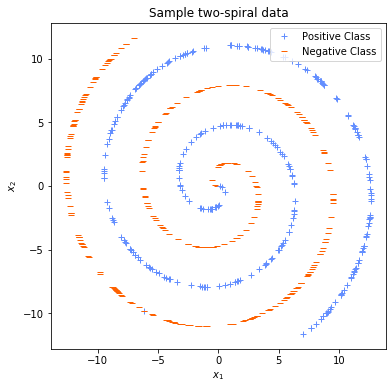

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Produces two spirals
def twoSpirals(N):
  np.random.seed(1)
  n = np.sqrt(np.random.rand(N,1)) * 780 * (2*np.pi)/360
  x = -np.cos(n)*n
  y = np.sin(n)*n
  return (np.vstack((np.hstack((x,y)),np.hstack((-x,-y)))), 
          np.hstack((np.ones(N)*-1,np.ones(N))))

X, y = twoSpirals(300)
fig = plt.figure(figsize=(6,6))

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if (y[i] == 1):
    plt.plot(x1,x2,'+', color='#648fff')
  else:
    plt.plot(x1,x2,'k_', color='#fe6100')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Sample two-spiral data')
plt.axis('tight')
plt.savefig('ch.6.two-spiral.data.png', dpi=350, bbox_inches='tight')
# plt.savefig('ch.6.two-spiral.data.eps', dpi=350, bbox_inches='tight')
plt.show()

### Verification steps

In [ ]:
print(X[0])
yv = np.zeros(X.shape)
yv[y==1,0]=1
yv[y==-1,1]=1
print(yv[0])
np.random.seed(1)
w1 = 2.0*np.random.random((2, 3))-1.0
w2 = 2.0*np.random.random((3, 2))-1.0
print(w1)
print(w2)

print(X[0].dot(w1))
print(1.0/(1.0+np.exp(-X[0].dot(w1))))

z1 = X[0].dot(w1)
o1 = 1.0/(1.0+np.exp(-X[0].dot(w1)))
print(o1.dot(w2))
o2 = 1.0/(1.0+np.exp(-o1.dot(w2)))
print(o2)

print(- ([1,0] - o2))
print(o1.dot(w2) * (1- o1.dot(w2)))

a=np.array([[-0.52476045, 0.50415211]])
b=np.array([[-0.10894822,  0.01633295]])
c=np.array([[3.79325728e-02, 3.64802735e-01, 1.20447478e-05]])
print(a*b)
np.set_printoptions(suppress=True)
print(c.T.dot(a*b))

print(w2 - (0.001 * (c.T.dot(a*b))))

print((a*b).dot(w2.T))

print(o1*(1-z1))


p=X[0].reshape((1,2))
q=(a*b).dot(w2.T)
r=o1*(1-z1)
print(p.T*(q*r))

print(w1-(0.001*(p.T*(q*r))))
np.set_printoptions(suppress=False)

from sklearn.preprocessing import StandardScaler
X_old = X
X = StandardScaler().fit_transform(X_old)

[7.08535569 5.20423916]
[0. 1.]
[[-0.16595599  0.44064899 -0.99977125]
 [-0.39533485 -0.70648822 -0.81532281]]
[[-0.62747958 -0.30887855]
 [-0.20646505  0.07763347]
 [-0.16161097  0.370439  ]]
[ -3.23327435  -0.55457885 -11.32686981]
[3.79325728e-02 3.64802735e-01 1.20447478e-05]
[-0.09912288  0.01660881]
[0.47523955 0.50415211]
[-0.52476045  0.50415211]
[-0.10894822  0.01633295]
[[0.05717172 0.00823429]]
[[0.00216867 0.00031235]
 [0.0208564  0.00300389]
 [0.00000069 0.0000001 ]]
[[-0.62748175 -0.30887886]
 [-0.20648591  0.07763046]
 [-0.16161097  0.370439  ]]
[[-0.03841748 -0.0111647  -0.00618927]]
[0.16057899 0.56711462 0.00014847]
[[-0.04370984 -0.04486212 -0.00000651]
 [-0.03210516 -0.03295151 -0.00000478]]
[[-0.16591228  0.44069385 -0.99977124]
 [-0.39530275 -0.70645527 -0.81532281]]


### Backprop over MLP on the two-spirals dataset

In [ ]:
#Largely inspired by Omar U. Florez's

def sigmoid(z, grad=False):
  if grad:
    return z*(1.0-z)
  return 1.0/(1.0+np.exp(-z))

def tanh(z, grad=True):
  if grad:
    return (1.0-z*z)
  return (1.0-np.exp(-z))/(1.0+np.exp(-z))

def inference(data, weights):
  o1 = sigmoid(np.matmul(data, weights[0]))
  logits = np.matmul(o1, weights[1])
  probs = np.exp(logits)/np.sum(np.exp(logits), axis=1, keepdims=True)
  return np.argmax(probs, axis=1)

#size of minibatch: int(X.shape[0])
N = 50

input_dim = int(X.shape[1])
hidden_dim = 3
output_dim = 2
num_epochs = 100000
learning_rate= 1e-3
reg_coeff = 1e-3
losses = []
accuracies=[]

#-------------------------------------------------------------------------------
# Initialize weights:
np.random.seed(1)
w1 = 2.0*np.random.random((input_dim, hidden_dim))-1.0      #w0=(2,hidden_dim)
w2 = 2.0*np.random.random((hidden_dim, output_dim))-1.0     #w1=(hidden_dim,2)

#Calibratring variances with 1/sqrt(fan_in)
w1 /= np.sqrt(input_dim)
w2 /= np.sqrt(hidden_dim)
for i in range(num_epochs):
  index = np.arange(X.shape[0])
  np.random.shuffle(index)
  index = index[:N]
  #shuffle indices

  #-----------------------------------------------------------------------------
  # Forward step:
  o1 = sigmoid(np.matmul(X[index], w1))                   #(N, 3)
  logits = sigmoid(np.matmul(o1, w2))                     #(N, 2)
  probs = np.exp(logits)/np.sum(np.exp(logits), axis=1, keepdims=True)
  o2 = logits

  #-----------------------------------------------------------------------------
  # Definition of Loss function: mean squared error plus Ridge regularization
  L = np.square(yv[index]-o2).sum()/(2*N) + reg_coeff*(np.square(w1).sum()+np.square(w2).sum())/(2*N)

  losses.append([i,L])

  #-----------------------------------------------------------------------------
  # Backward step: Error = W_l e_l+1 f'_l
  #       dL/dw2 = dL/do2 * do2/dz2 * dz2/dw2
  dL_do2 = -(yv[index] - o2)                               #(N, 2)
  do2_dz2 = sigmoid(o2, grad=True)            #(N, 2)
  dz2_dw2 = o1                                            #(N, hidden_dim)
  #Gradient for weight2:   (hidden_dim,N)x(N,2)*(N,2)
  dL_dw2 = dz2_dw2.T.dot(dL_do2*do2_dz2) + reg_coeff*np.square(w2).sum()

  #dL/dw1 = dL/do1 * do1/dz1 * dz1/dw1
  #       dL/do1 = dL/dz2 * dz2/do1
  #       dL/dz2 = dL/do2 * do2/dz2
  dL_dz2 = dL_do2 * do2_dz2                               #(N, 2)
  dz2_do1 = w2                                            #z2 = o1*w2
  dL_do1 =  dL_dz2.dot(dz2_do1.T)                         #(N,2)x(2, hidden_dim)=(N, hidden_dim)
  do1_dz1 = sigmoid(o1, grad=True)            #(N,hidden_dim)
  dz1_dw1 = X[index]                                      #(N,2)
  #Gradient for weight1:  (2,N)x((N,hidden_dim)*(N,hidden_dim))
  dL_dw1 = dz1_dw1.T.dot(dL_do1*do1_dz1) + reg_coeff*np.square(w1).sum()

  #weight updates:
  w2 += -learning_rate*dL_dw2
  w1 += -learning_rate*dL_dw1
  if True: #(i+1)%1000==0:
    y_pred = inference(X, [w1, w2])
    y_actual = np.argmax(yv, axis=1)
    accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)
    accuracies.append([i, accuracy])



[0.61785329 0.37812645] [0. 1.]


(array([5., 5., 6., 5., 5., 3., 5., 6., 4., 6.]),
 array([0.27173394, 0.31843704, 0.36514014, 0.41184323, 0.45854633,
        0.50524942, 0.55195252, 0.59865562, 0.64535871, 0.69206181,
        0.73876491]),
 <a list of 10 Patch objects>)

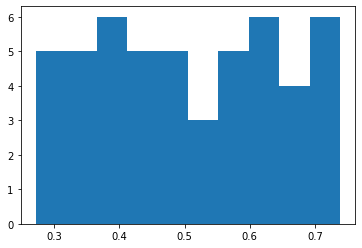

In [ ]:
print(o2[0], yv[index][0])
plt.hist(o2[:,0])

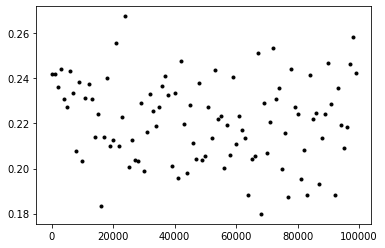

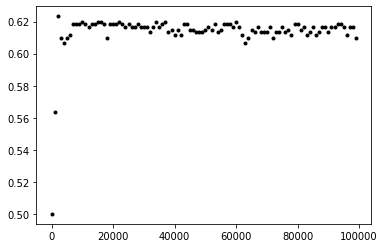

In [ ]:
plt.figure()
for k in range(len(losses)):
  if k%1000==0:
    plt.plot(losses[k][0], losses[k][1], 'k.')
plt.show()

plt.figure()
for k in range(len(accuracies)):
  if k%1000==0:
    plt.plot(accuracies[k][0], accuracies[k][1], 'k.')
plt.show()

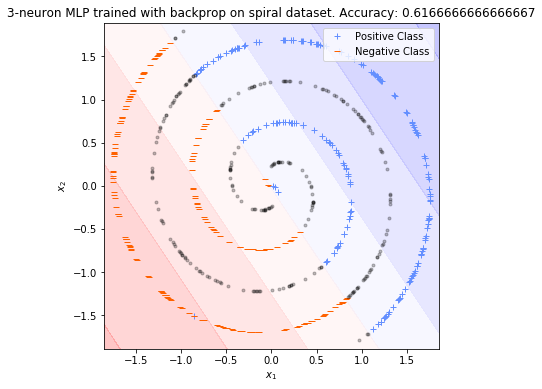

In [ ]:
def getprobas(data, weights):
  o1 = sigmoid(np.matmul(data, weights[0]))
  logits = np.matmul(o1, weights[1])
  return logits

y_pred = inference(X, [w1, w2])
y_actual = np.argmax(yv, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = getprobas(np.c_[xx.ravel(), yy.ravel()], [w1, w2])[:, 1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('3-neuron MLP trained with backprop on spiral dataset. Accuracy: '+str(accuracy))
plt.savefig('ch.6.MLP.bp.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

## Hyper-parameter optimization experiments
Run these as many times as you wish

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

mlp = Sequential()
mlp.add(Dense(3, input_dim=2, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

# reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5,
#                               patience=100, min_lr=0.00000001,
#                               verbose = 1)

mlp.compile(loss='mean_squared_error',
            optimizer='sgd',
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=60,
        verbose=1, #callbacks=[reduce_lr], 
        validation_split = 0.1)

Train on 540 samples, validate on 60 samples
Epoch 1/1000
540/540 [==============================] - 2s 4ms/sample - loss: 0.2965 - accuracy: 0.4444 - val_loss: 0.1488 - val_accuracy: 1.0000
Epoch 2/1000
540/540 [==============================] - 0s 46us/sample - loss: 0.2958 - accuracy: 0.4444 - val_loss: 0.1499 - val_accuracy: 1.0000
Epoch 3/1000
540/540 [==============================] - 0s 47us/sample - loss: 0.2952 - accuracy: 0.4444 - val_loss: 0.1509 - val_accuracy: 1.0000
Epoch 4/1000
540/540 [==============================] - 0s 48us/sample - loss: 0.2946 - accuracy: 0.4444 - val_loss: 0.1519 - val_accuracy: 1.0000
Epoch 5/1000
540/540 [==============================] - 0s 48us/sample - loss: 0.2940 - accuracy: 0.4444 - val_loss: 0.1529 - val_accuracy: 1.0000
Epoch 6/1000
540/540 [==============================] - 0s 46us/sample - loss: 0.2934 - accuracy: 0.4444 - val_loss: 0.1539 - val_accuracy: 1.0000
Epoch 7/1000
540/540 [==============================] - 0s 47us/sample - l

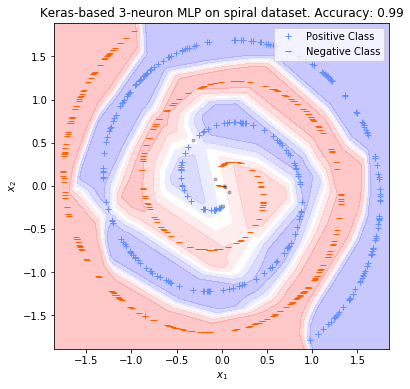

In [ ]:
y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 3-neuron MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Experiments continued

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 391us/sample - loss: 0.7374 - accuracy: 0.4798 - val_loss: 0.6502 - val_accuracy: 0.7500
Epoch 2/1000
594/594 [==============================] - 0s 27us/sample - loss: 0.6991 - accuracy: 0.4815 - val_loss: 0.6931 - val_accuracy: 0.2500
Epoch 3/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6937 - accuracy: 0.5059 - val_loss: 0.6898 - val_accuracy: 0.3333
Epoch 4/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6906 - accuracy: 0.5404 - val_loss: 0.7308 - val_accuracy: 0.0833
Epoch 5/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6853 - accuracy: 0.5623 - val_loss: 0.7228 - val_accuracy: 0.1667
Epoch 6/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6809 - accuracy: 0.6010 - val_loss: 0.7091 - val_accuracy: 0.2500
Epoch 7/1000
594/594 [==============================] - 0s 24us/sample - 

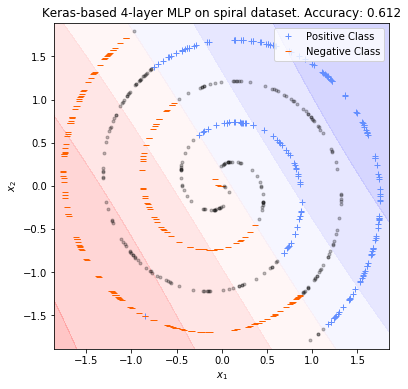

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.a.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 414us/sample - loss: 0.6704 - accuracy: 0.5328 - val_loss: 0.6627 - val_accuracy: 0.5833
Epoch 2/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6587 - accuracy: 0.5572 - val_loss: 0.6850 - val_accuracy: 0.4167
Epoch 3/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6511 - accuracy: 0.5842 - val_loss: 0.7076 - val_accuracy: 0.3333
Epoch 4/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6464 - accuracy: 0.5951 - val_loss: 0.7248 - val_accuracy: 0.3333
Epoch 5/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6428 - accuracy: 0.6035 - val_loss: 0.7455 - val_accuracy: 0.3333
Epoch 6/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6405 - accuracy: 0.6111 - val_loss: 0.7580 - val_accuracy: 0.3333
Epoch 7/1000
594/594 [==============================] - 0s 23us/sample - 

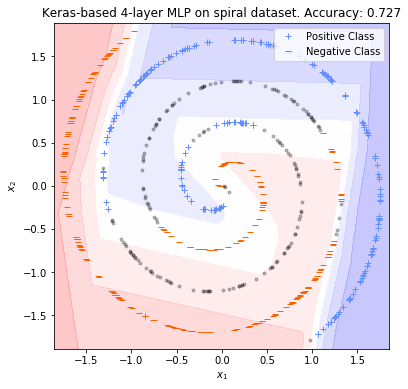

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.b.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 433us/sample - loss: 0.7409 - accuracy: 0.5000 - val_loss: 0.7555 - val_accuracy: 0.2500
Epoch 2/1000
594/594 [==============================] - 0s 28us/sample - loss: 0.6915 - accuracy: 0.5370 - val_loss: 0.7271 - val_accuracy: 0.0833
Epoch 3/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6880 - accuracy: 0.5303 - val_loss: 0.6933 - val_accuracy: 0.4167
Epoch 4/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6872 - accuracy: 0.5673 - val_loss: 0.6938 - val_accuracy: 0.4167
Epoch 5/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6872 - accuracy: 0.5614 - val_loss: 0.7137 - val_accuracy: 0.0833
Epoch 6/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6867 - accuracy: 0.5505 - val_loss: 0.6866 - val_accuracy: 0.4167
Epoch 7/1000
594/594 [==============================] - 0s 24us/sample - 

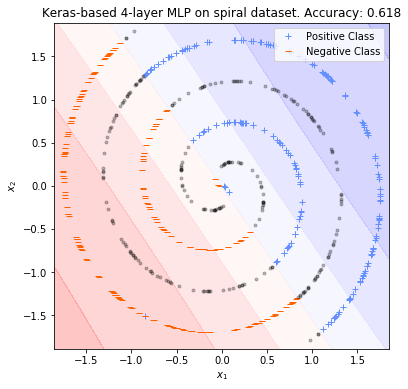

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='sigmoid'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.c.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 438us/sample - loss: 0.7359 - accuracy: 0.5000 - val_loss: 0.7219 - val_accuracy: 0.5000
Epoch 2/1000
594/594 [==============================] - 0s 30us/sample - loss: 0.6928 - accuracy: 0.5320 - val_loss: 0.7328 - val_accuracy: 0.0833
Epoch 3/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6893 - accuracy: 0.5210 - val_loss: 0.7202 - val_accuracy: 0.0833
Epoch 4/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6887 - accuracy: 0.5261 - val_loss: 0.7358 - val_accuracy: 0.0000e+00
Epoch 5/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6861 - accuracy: 0.5732 - val_loss: 0.7215 - val_accuracy: 0.1667
Epoch 6/1000
594/594 [==============================] - 0s 21us/sample - loss: 0.6844 - accuracy: 0.5556 - val_loss: 0.7138 - val_accuracy: 0.2500
Epoch 7/1000
594/594 [==============================] - 0s 24us/sampl

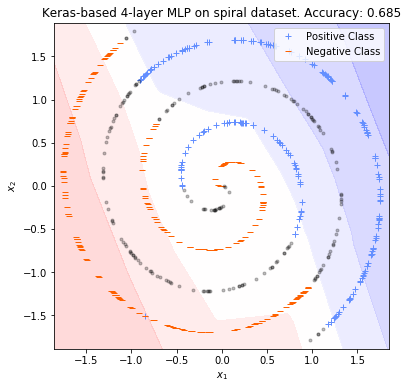

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.d.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 460us/sample - loss: 0.7138 - accuracy: 0.5000 - val_loss: 0.7345 - val_accuracy: 0.0000e+00
Epoch 2/1000
594/594 [==============================] - 0s 29us/sample - loss: 0.6943 - accuracy: 0.5051 - val_loss: 0.6903 - val_accuracy: 0.8333
Epoch 3/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6963 - accuracy: 0.4554 - val_loss: 0.6656 - val_accuracy: 1.0000
Epoch 4/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6945 - accuracy: 0.4949 - val_loss: 0.7244 - val_accuracy: 0.0000e+00
Epoch 5/1000
594/594 [==============================] - 0s 27us/sample - loss: 0.6941 - accuracy: 0.4512 - val_loss: 0.7166 - val_accuracy: 0.0000e+00
Epoch 6/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6939 - accuracy: 0.4537 - val_loss: 0.7161 - val_accuracy: 0.0000e+00
Epoch 7/1000
594/594 [==============================] - 0

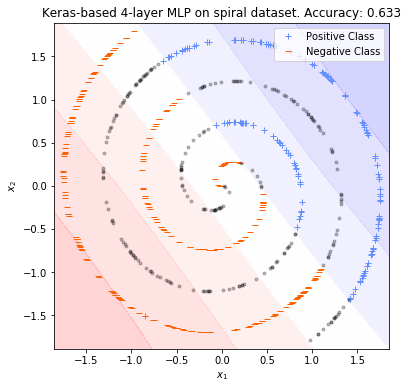

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='sigmoid'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.e.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 469us/sample - loss: 0.6987 - accuracy: 0.4949 - val_loss: 0.7272 - val_accuracy: 0.1667
Epoch 2/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6971 - accuracy: 0.4924 - val_loss: 0.6153 - val_accuracy: 1.0000
Epoch 3/1000
594/594 [==============================] - 0s 21us/sample - loss: 0.6943 - accuracy: 0.4949 - val_loss: 0.7993 - val_accuracy: 0.0000e+00
Epoch 4/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6922 - accuracy: 0.5303 - val_loss: 0.7170 - val_accuracy: 0.0833
Epoch 5/1000
594/594 [==============================] - 0s 21us/sample - loss: 0.6909 - accuracy: 0.5286 - val_loss: 0.6366 - val_accuracy: 1.0000
Epoch 6/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6930 - accuracy: 0.4949 - val_loss: 0.8502 - val_accuracy: 0.0000e+00
Epoch 7/1000
594/594 [==============================] - 0s 24us/s

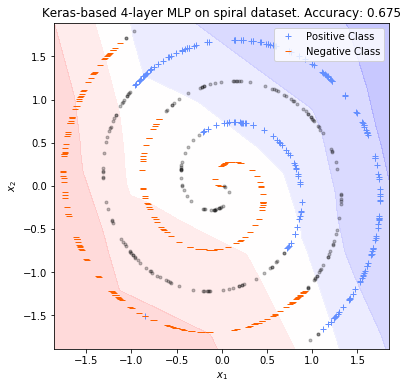

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.f.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 452us/sample - loss: 0.6923 - accuracy: 0.5219 - val_loss: 0.6769 - val_accuracy: 0.7500
Epoch 2/1000
594/594 [==============================] - 0s 27us/sample - loss: 0.6857 - accuracy: 0.5244 - val_loss: 0.6730 - val_accuracy: 0.5833
Epoch 3/1000
594/594 [==============================] - 0s 28us/sample - loss: 0.6805 - accuracy: 0.5421 - val_loss: 0.6818 - val_accuracy: 0.4167
Epoch 4/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6756 - accuracy: 0.5513 - val_loss: 0.6872 - val_accuracy: 0.3333
Epoch 5/1000
594/594 [==============================] - 0s 28us/sample - loss: 0.6721 - accuracy: 0.5926 - val_loss: 0.6753 - val_accuracy: 0.3333
Epoch 6/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6655 - accuracy: 0.6077 - val_loss: 0.6994 - val_accuracy: 0.3333
Epoch 7/1000
594/594 [==============================] - 0s 33us/sample - 

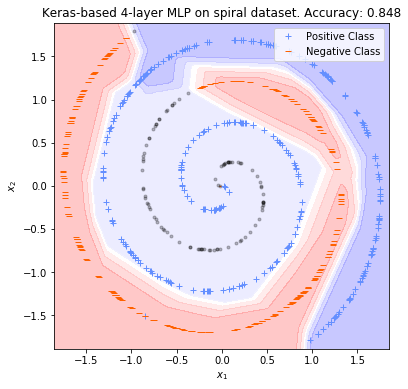

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.h.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 489us/sample - loss: 0.8531 - accuracy: 0.4949 - val_loss: 0.5854 - val_accuracy: 1.0000
Epoch 2/1000
594/594 [==============================] - 0s 29us/sample - loss: 0.6978 - accuracy: 0.4949 - val_loss: 0.7120 - val_accuracy: 0.0833
Epoch 3/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6942 - accuracy: 0.4781 - val_loss: 0.7142 - val_accuracy: 0.0833
Epoch 4/1000
594/594 [==============================] - 0s 28us/sample - loss: 0.6941 - accuracy: 0.5261 - val_loss: 0.6909 - val_accuracy: 0.5833
Epoch 5/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6943 - accuracy: 0.4958 - val_loss: 0.6855 - val_accuracy: 0.7500
Epoch 6/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6945 - accuracy: 0.4941 - val_loss: 0.6821 - val_accuracy: 0.8333
Epoch 7/1000
594/594 [==============================] - 0s 24us/sample - 

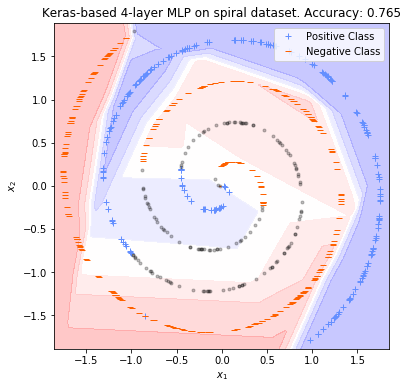

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.i.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 480us/sample - loss: 0.7010 - accuracy: 0.4907 - val_loss: 0.7151 - val_accuracy: 0.3333
Epoch 2/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6957 - accuracy: 0.4579 - val_loss: 0.7188 - val_accuracy: 0.3333
Epoch 3/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6938 - accuracy: 0.4857 - val_loss: 0.7089 - val_accuracy: 0.5000
Epoch 4/1000
594/594 [==============================] - 0s 30us/sample - loss: 0.6932 - accuracy: 0.5118 - val_loss: 0.7249 - val_accuracy: 0.1667
Epoch 5/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6936 - accuracy: 0.4949 - val_loss: 0.6763 - val_accuracy: 0.5833
Epoch 6/1000
594/594 [==============================] - 0s 28us/sample - loss: 0.6908 - accuracy: 0.5210 - val_loss: 0.7255 - val_accuracy: 0.1667
Epoch 7/1000
594/594 [==============================] - 0s 28us/sample - 

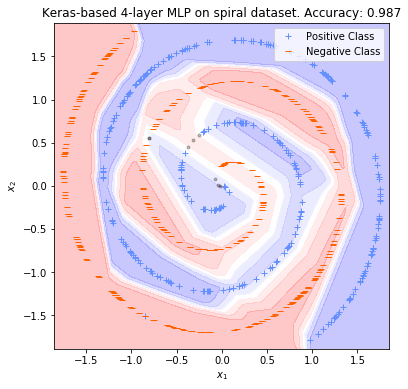

In [ ]:
y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.g.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 497us/sample - loss: 0.7033 - accuracy: 0.5000 - val_loss: 0.6716 - val_accuracy: 0.8333
Epoch 2/1000
594/594 [==============================] - 0s 23us/sample - loss: 0.6947 - accuracy: 0.4798 - val_loss: 0.6762 - val_accuracy: 1.0000
Epoch 3/1000
594/594 [==============================] - 0s 26us/sample - loss: 0.6919 - accuracy: 0.5455 - val_loss: 0.6965 - val_accuracy: 0.4167
Epoch 4/1000
594/594 [==============================] - 0s 25us/sample - loss: 0.6909 - accuracy: 0.5598 - val_loss: 0.7161 - val_accuracy: 0.0000e+00
Epoch 5/1000
594/594 [==============================] - 0s 22us/sample - loss: 0.6896 - accuracy: 0.5051 - val_loss: 0.6938 - val_accuracy: 0.5833
Epoch 6/1000
594/594 [==============================] - 0s 36us/sample - loss: 0.6899 - accuracy: 0.5715 - val_loss: 0.7305 - val_accuracy: 0.0000e+00
Epoch 7/1000
594/594 [==============================] - 0s 29us/s

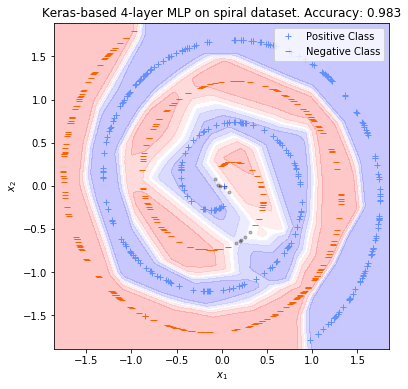

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.j.spirals.png', dpi=350, bbox_inches='tight')


plt.show()

Train on 594 samples, validate on 6 samples
Epoch 1/1000
594/594 [==============================] - 0s 544us/sample - loss: 0.7439 - accuracy: 0.5118 - val_loss: 0.7788 - val_accuracy: 0.0000e+00
Epoch 2/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6969 - accuracy: 0.4891 - val_loss: 0.7364 - val_accuracy: 0.0000e+00
Epoch 3/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6933 - accuracy: 0.5051 - val_loss: 0.7048 - val_accuracy: 0.0000e+00
Epoch 4/1000
594/594 [==============================] - 0s 29us/sample - loss: 0.6930 - accuracy: 0.5160 - val_loss: 0.7027 - val_accuracy: 0.0000e+00
Epoch 5/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6955 - accuracy: 0.4865 - val_loss: 0.7356 - val_accuracy: 0.0000e+00
Epoch 6/1000
594/594 [==============================] - 0s 24us/sample - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.7151 - val_accuracy: 0.0000e+00
Epoch 7/1000
594/594 [===========================

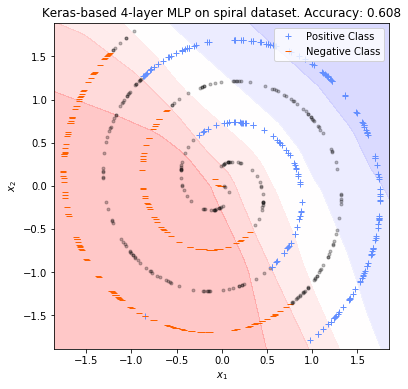

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

mlp = Sequential()
mlp.add(Dense(16, input_dim=2, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(16, activation='sigmoid'))
mlp.add(Dense(2, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='accuracy',
                              patience=50, min_lr=0.00000001,
                              verbose = 1)

stop_save = EarlyStopping(patience=200, monitor='accuracy',
                          verbose=1, 
                          restore_best_weights=True)

# All parameter gradients will be clipped to
# a maximum norm of 1.
sgd = optimizers.SGD(lr=1., clipnorm=1.)

mlp.compile(loss='binary_crossentropy',
            optimizer=sgd,
            metrics=['accuracy'])

# trains the model
mlp.fit(X, yv, epochs=1000, batch_size=297,
        verbose=1, callbacks=[reduce_lr, stop_save], 
        validation_split = 0.01)

y_pred = mlp.predict(X)
y_pred = np.argmax(y_pred, axis=1)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = None
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
cm = plt.cm.bwr

fig = plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z, cmap=cm, alpha=.25)

plt.plot(X[1,0],X[1,1],'+', color='#648fff', label='Positive Class')
plt.plot(X[2,1],X[2,1],'_', color='#fe6100', label='Negative Class')

for i in range(len(y)):
  x1 = X[i,0]
  x2 = X[i,1]
  if y[i]==1: 
    if (y_pred[i] == 0):
      plt.plot(x1,x2,'+', color='#648fff')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)
  else:
    if (y_pred[i] == 1):
      plt.plot(x1,x2,'_', color='#fe6100')
    else:
      plt.plot(x1,x2,'k.', alpha=0.25)

accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)

plt.axis('tight')
plt.xlim(min(X[:,0])-0.1, max(X[:,0])+0.1)
plt.ylim(min(X[:,1])-0.1, max(X[:,1])+0.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.title('Keras-based 4-layer MLP on spiral dataset. Accuracy: {:04.3}'.format(accuracy))
plt.savefig('ch.6.MLP.keras.deep.k.spirals.png', dpi=350, bbox_inches='tight')

plt.show()